In [1]:
from sys import path
path.append('..')
path.append('../../src/')

import os
import cv2
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import random as rn
import tensorflow as tf
from os.path import basename, join, exists
from sys import stdout

from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, UpSampling2D, GlobalAvgPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model

from skmultilearn.model_selection import iterative_train_test_split

from tensorflow.contrib.tensorboard.plugins import projector

from global_config import RANDOM_SEED, IMAGE_SIZE, FOLDER_IMAGES, FOLDER_MRKS
from local_config import FOLDER_MODELS, FILE_AUTOENCODER_SAMPLES, FILE_DATASET
from custom_metrics import precision, recall, f1, specificity, fbeta
from custom_metrics import negative_predictive_value as npv 
from custom_metrics import matthews_correlation_coefficient as mcc
from icao_dataset import ICAODataset
from data_structures import Point
from utils import plot, load

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
PATH_TO_ROOT = '../../'

FOLDER_LOGS = join(PATH_TO_ROOT, 'logs')
FOLDER_MODELS = join(PATH_TO_ROOT, FOLDER_MODELS)
FILE_DATASET = join(PATH_TO_ROOT, FILE_DATASET)
FILE_AUTOENCODER_SAMPLES = join(PATH_TO_ROOT, FILE_AUTOENCODER_SAMPLES)

print(FOLDER_LOGS)
print(FOLDER_MODELS)
print(FILE_DATASET)
print(FILE_AUTOENCODER_SAMPLES)

../../logs
../../models/unsupervised_supervised/
../../data/cropped_faces/dataset_normalized.pkl
../../data/unsupervised_supervised_samples.pkl


In [3]:
TEST_SIZE = 0.1
MLFLOW_EXPERIMENT_NAME = 'Unsupervised + Supervised'

In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'


def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)

# Data Loading 

In [5]:
if exists(FILE_DATASET):
    print("Dataset found. Loading...")
    dataset = pkl.load(open(FILE_DATASET, "rb"))
else:
    print("Generating dataset...")
    dataset = ICAODataset()
    dataset.load(FOLDER_IMAGES, FOLDER_MRKS, output_size=(160, 160))
    pkl.dump(dataset, open(FILE_DATASET, "wb"))

Dataset found. Loading...


In [6]:
x = dataset.images
mrks = dataset.mrks
y_reqs = np.array([mrk_file.photo_reqs.values() for mrk_file in mrks])
y_eyes = np.array([mrk_file.right_eye.as_list() + mrk_file.left_eye.as_list() for mrk_file in mrks])

print(x.shape, x.dtype)
print(y_reqs.shape, y_reqs.dtype)
print(y_eyes.shape, y_eyes.dtype)
print(len(mrks))

(5731, 160, 160, 3) float32
(5731, 23) int32
(5731, 8) float64
5731


#### divide train and test

In [7]:
np.random.seed(RANDOM_SEED)
x_train_idx, y_train_reqs, x_val_idx, y_val_reqs = iterative_train_test_split(
    np.arange(x.shape[0]).reshape(-1, 1),
    y_reqs,
    test_size=TEST_SIZE
)
x_train_idx = x_train_idx.ravel()
x_val_idx = x_val_idx.ravel()

x_train = x[x_train_idx]
x_val = x[x_val_idx]

y_train_eyes = y_eyes[x_train_idx]
y_val_eyes = y_eyes[x_val_idx]

print(x_train.shape, y_train_reqs.shape, y_train_eyes.shape)
print(x_val.shape, y_val_reqs.shape, y_val_eyes.shape)

(5151, 160, 160, 3) (5151, 23) (5151, 8)
(580, 160, 160, 3) (580, 23) (580, 8)


In [8]:
train_mrks = mrks[x_train_idx]
val_mrks = mrks[x_val_idx]

# Model Training 

In [9]:
x_train /= 255.0
x_val /= 255.0

print(x_train.shape, x_train.dtype, x_train.min(), x_train.max())
print(x_val.shape, x_val.dtype, x_val.min(), x_val.max())

(5151, 160, 160, 3) float32 0.0 1.0
(580, 160, 160, 3) float32 0.0 1.0


In [10]:
def conv_bn(idx, prev_input, filters, activation='relu', name=None):
    conv_name = 'conv_' + str(idx)
    bn_name = 'bn_' + str(idx)
    act_name = f'{activation}_' + str(idx) if name is None else name
    
    conv = Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', activation=None, name=conv_name)(prev_input)
    conv = BatchNormalization(axis=-1, name=bn_name)(conv)
    conv = Activation(activation, name=act_name)(conv)
    return conv


def conv_bn_maxpool(idx, prev_input, filters):
    pool_name = 'pool_' + str(idx)
    
    conv = conv_bn(idx, prev_input, filters)
    pool = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid', name=pool_name)(conv)
    return pool


def deconv_bn(idx, prev_input, filters, activation='relu'):
    bn_name = str(idx) + '_bn' 
    act_name = str(idx) + '_relu' 
    conv_name = str(idx) + '_conv' 
    
    deconv = Conv2DTranspose(filters, kernel_size=(3, 3), strides=(2, 2), padding='same', activation=None, name=conv_name)(prev_input)
    deconv = BatchNormalization(axis=-1, name=bn_name)(deconv)
    deconv = Activation(activation, name=act_name)(deconv)
    return deconv


def dense_layer(idx, prev_input, units, dropout=True, rate=0.5, activation='relu'):
    dense_name = f"dense_{idx}"
    drop_name = f"dropout_{idx}"
    
    if dropout:
        prev_input = Dropout(rate)(prev_input)
    out = Dense(units, activation=activation)(prev_input)
    return out

In [11]:
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("seed", RANDOM_SEED)
mlflow.keras.autolog()

set_random_seeds()
N_REQS = y_train_reqs.shape[1]
N_EYES = y_train_eyes.shape[1]

inputs = Input(shape=x_train.shape[1:], name='input')
pool_1 = conv_bn_maxpool(1, inputs, 32)
pool_2 = conv_bn_maxpool(2, pool_1, 64)
pool_3 = conv_bn_maxpool(3, pool_2, 128)
pool_4 = conv_bn_maxpool(4, pool_3, 256)
encode = conv_bn(5, pool_4, 256, activation='tanh', name='encoded')

dec_4 = deconv_bn(4, encode, 256)
dec_3 = deconv_bn(3, dec_4, 128)
dec_2 = deconv_bn(2, dec_3, 64)
dec_1 = deconv_bn(1, dec_2, 32)
decoded = Conv2D(filters=3, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='sigmoid', name='decoded')(dec_1)

avg_pool = GlobalAvgPool2D()(encode)
dense_1 = dense_layer(1, avg_pool, 64)
dense_2 = dense_layer(2, dense_1, 32)
classif = Dense(units=N_REQS, activation='sigmoid', name='output_reqs')(dense_2)

dense_3 = dense_layer(3, avg_pool, 64)
dense_4 = dense_layer(4, dense_3, 32)
regress = Dense(units=N_EYES, activation='linear', name='output_eyes')(dense_4)

model = Model(inputs=inputs, outputs=[decoded, classif, regress])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 160, 160, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 160, 160, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 160, 160, 32) 0           bn_1[0][0]                       
____________________________________________________________________________________________

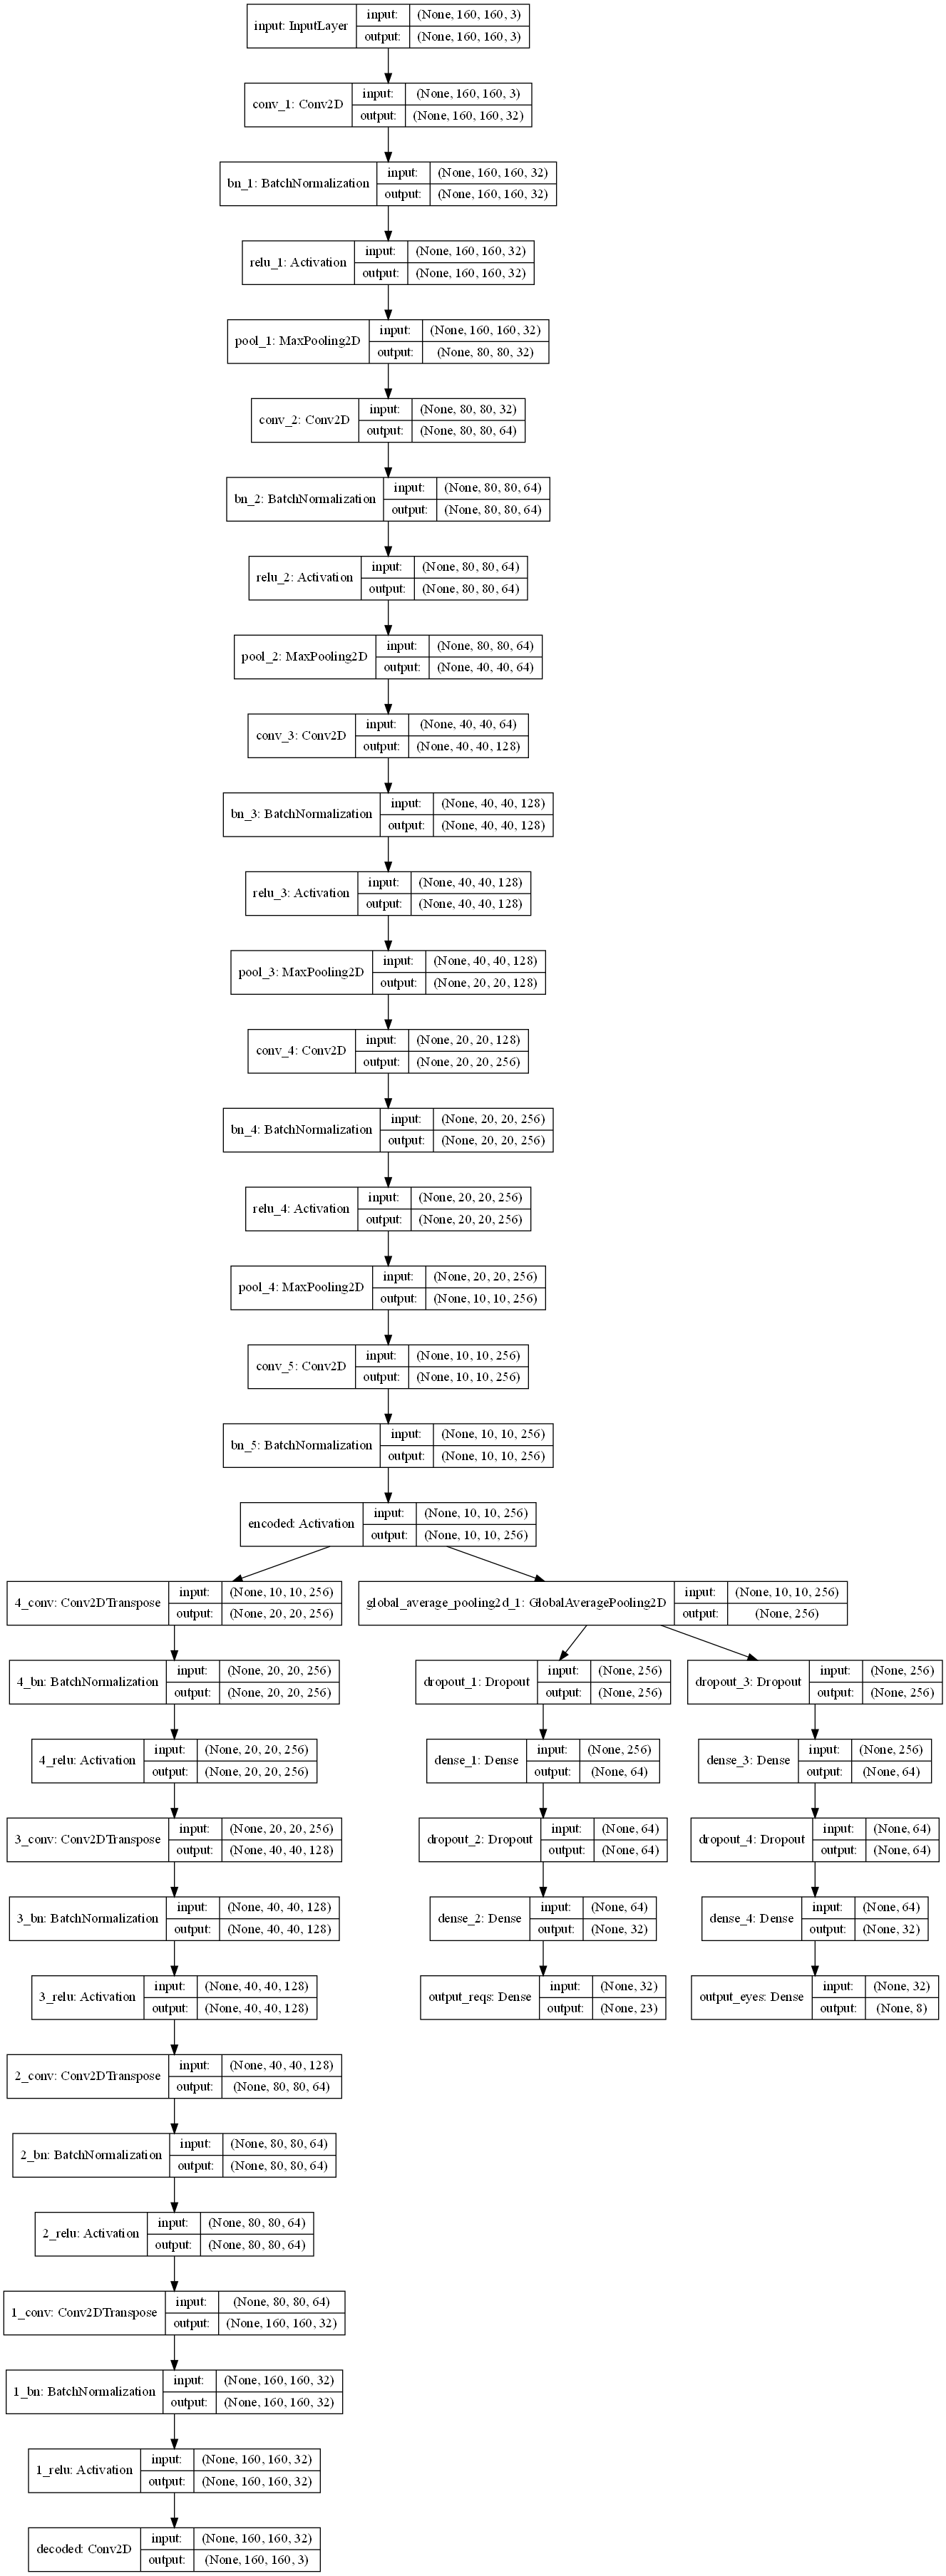

In [12]:
plot_model(model, show_shapes=True)

Instructions for updating:
Use tf.cast instead.
Train on 5151 samples, validate on 580 samples
Epoch 1/100
5151/5151 [==============================] - 59s 12ms/step - loss: 0.6290 - decoded_loss: 0.0222 - output_reqs_loss: 0.4803 - output_eyes_loss: 0.1042 - output_reqs_accuracy: 0.7771 - output_reqs_precision: 0.8214 - output_reqs_recall: 0.9209 - output_reqs_f1: 0.8660 - output_reqs_fbeta: 0.8946 - output_reqs_specificity: 0.2067 - output_reqs_negative_predictive_value: 0.4790 - output_reqs_matthews_correlation_coefficient: 0.1932 - output_eyes_mae: 0.2409 - val_loss: 0.8175 - val_decoded_loss: 0.1147 - val_output_reqs_loss: 0.5127 - val_output_eyes_loss: 0.0821 - val_output_reqs_accuracy: 0.7927 - val_output_reqs_precision: 0.7936 - val_output_reqs_recall: 0.9745 - val_output_reqs_f1: 0.8735 - val_output_reqs_fbeta: 0.9283 - val_output_reqs_specificity: 0.1142 - val_output_reqs_negative_predictive_value: 0.5569 - val_output_reqs_matthews_correlation_coefficient: 0.1759 - val_output


Epoch 00008: val_output_reqs_fbeta did not improve from 0.95688
Epoch 9/100
5151/5151 [==============================] - 53s 10ms/step - loss: 0.3311 - decoded_loss: 0.0075 - output_reqs_loss: 0.3002 - output_eyes_loss: 0.0159 - output_reqs_accuracy: 0.8672 - output_reqs_precision: 0.8839 - output_reqs_recall: 0.9600 - output_reqs_f1: 0.9202 - output_reqs_fbeta: 0.9412 - output_reqs_specificity: 0.4989 - output_reqs_negative_predictive_value: 0.7569 - output_reqs_matthews_correlation_coefficient: 0.5416 - output_eyes_mae: 0.0515 - val_loss: 0.4593 - val_decoded_loss: 0.0106 - val_output_reqs_loss: 0.4417 - val_output_eyes_loss: 0.0291 - val_output_reqs_accuracy: 0.8492 - val_output_reqs_precision: 0.8728 - val_output_reqs_recall: 0.9283 - val_output_reqs_f1: 0.8981 - val_output_reqs_fbeta: 0.9131 - val_output_reqs_specificity: 0.5456 - val_output_reqs_negative_predictive_value: 0.6746 - val_output_reqs_matthews_correlation_coefficient: 0.5084 - val_output_eyes_mae: 0.0684

Epoch 00009

5151/5151 [==============================] - 52s 10ms/step - loss: 0.2827 - decoded_loss: 0.0061 - output_reqs_loss: 0.2593 - output_eyes_loss: 0.0111 - output_reqs_accuracy: 0.8875 - output_reqs_precision: 0.9020 - output_reqs_recall: 0.9640 - output_reqs_f1: 0.9319 - output_reqs_fbeta: 0.9488 - output_reqs_specificity: 0.5836 - output_reqs_negative_predictive_value: 0.8021 - output_reqs_matthews_correlation_coefficient: 0.6205 - output_eyes_mae: 0.0401 - val_loss: 0.3520 - val_decoded_loss: 0.0091 - val_output_reqs_loss: 0.2473 - val_output_eyes_loss: 0.0984 - val_output_reqs_accuracy: 0.8938 - val_output_reqs_precision: 0.9412 - val_output_reqs_recall: 0.9140 - val_output_reqs_f1: 0.9269 - val_output_reqs_fbeta: 0.9193 - val_output_reqs_specificity: 0.8192 - val_output_reqs_negative_predictive_value: 0.7256 - val_output_reqs_matthews_correlation_coefficient: 0.6983 - val_output_eyes_mae: 0.2636

Epoch 00017: val_output_reqs_fbeta did not improve from 0.95824
Epoch 18/100
5151/5151 [

5151/5151 [==============================] - 52s 10ms/step - loss: 0.2550 - decoded_loss: 0.0056 - output_reqs_loss: 0.2357 - output_eyes_loss: 0.0081 - output_reqs_accuracy: 0.9000 - output_reqs_precision: 0.9139 - output_reqs_recall: 0.9659 - output_reqs_f1: 0.9391 - output_reqs_fbeta: 0.9529 - output_reqs_specificity: 0.6384 - output_reqs_negative_predictive_value: 0.8238 - output_reqs_matthews_correlation_coefficient: 0.6674 - output_eyes_mae: 0.0349 - val_loss: 0.2670 - val_decoded_loss: 0.0066 - val_output_reqs_loss: 0.2651 - val_output_eyes_loss: 0.0117 - val_output_reqs_accuracy: 0.9042 - val_output_reqs_precision: 0.9256 - val_output_reqs_recall: 0.9398 - val_output_reqs_f1: 0.9318 - val_output_reqs_fbeta: 0.9359 - val_output_reqs_specificity: 0.7630 - val_output_reqs_negative_predictive_value: 0.7814 - val_output_reqs_matthews_correlation_coefficient: 0.7037 - val_output_eyes_mae: 0.0369

Epoch 00025: val_output_reqs_fbeta did not improve from 0.95824
Epoch 26/100
5151/5151 [

5151/5151 [==============================] - 52s 10ms/step - loss: 0.2347 - decoded_loss: 0.0054 - output_reqs_loss: 0.2158 - output_eyes_loss: 0.0081 - output_reqs_accuracy: 0.9100 - output_reqs_precision: 0.9228 - output_reqs_recall: 0.9684 - output_reqs_f1: 0.9450 - output_reqs_fbeta: 0.9570 - output_reqs_specificity: 0.6782 - output_reqs_negative_predictive_value: 0.8433 - output_reqs_matthews_correlation_coefficient: 0.7035 - output_eyes_mae: 0.0331 - val_loss: 0.2596 - val_decoded_loss: 0.0069 - val_output_reqs_loss: 0.2424 - val_output_eyes_loss: 0.0123 - val_output_reqs_accuracy: 0.9142 - val_output_reqs_precision: 0.9342 - val_output_reqs_recall: 0.9497 - val_output_reqs_f1: 0.9414 - val_output_reqs_fbeta: 0.9455 - val_output_reqs_specificity: 0.7863 - val_output_reqs_negative_predictive_value: 0.8152 - val_output_reqs_matthews_correlation_coefficient: 0.7418 - val_output_eyes_mae: 0.0384

Epoch 00033: val_output_reqs_fbeta did not improve from 0.96352
Epoch 34/100
5151/5151 [

5151/5151 [==============================] - 52s 10ms/step - loss: 0.2155 - decoded_loss: 0.0048 - output_reqs_loss: 0.1990 - output_eyes_loss: 0.0068 - output_reqs_accuracy: 0.9177 - output_reqs_precision: 0.9289 - output_reqs_recall: 0.9713 - output_reqs_f1: 0.9496 - output_reqs_fbeta: 0.9606 - output_reqs_specificity: 0.7053 - output_reqs_negative_predictive_value: 0.8596 - output_reqs_matthews_correlation_coefficient: 0.7302 - output_eyes_mae: 0.0314 - val_loss: 0.2863 - val_decoded_loss: 0.0057 - val_output_reqs_loss: 0.2732 - val_output_eyes_loss: 0.0110 - val_output_reqs_accuracy: 0.9092 - val_output_reqs_precision: 0.9416 - val_output_reqs_recall: 0.9330 - val_output_reqs_f1: 0.9368 - val_output_reqs_fbeta: 0.9333 - val_output_reqs_specificity: 0.8151 - val_output_reqs_negative_predictive_value: 0.7768 - val_output_reqs_matthews_correlation_coefficient: 0.7320 - val_output_eyes_mae: 0.0358

Epoch 00041: val_output_reqs_fbeta did not improve from 0.96352
Epoch 42/100
5151/5151 [

5151/5151 [==============================] - 52s 10ms/step - loss: 0.1976 - decoded_loss: 0.0049 - output_reqs_loss: 0.1820 - output_eyes_loss: 0.0059 - output_reqs_accuracy: 0.9249 - output_reqs_precision: 0.9362 - output_reqs_recall: 0.9723 - output_reqs_f1: 0.9538 - output_reqs_fbeta: 0.9631 - output_reqs_specificity: 0.7369 - output_reqs_negative_predictive_value: 0.8693 - output_reqs_matthews_correlation_coefficient: 0.7555 - output_eyes_mae: 0.0288 - val_loss: 0.4082 - val_decoded_loss: 0.0070 - val_output_reqs_loss: 0.3787 - val_output_eyes_loss: 0.0178 - val_output_reqs_accuracy: 0.8865 - val_output_reqs_precision: 0.9333 - val_output_reqs_recall: 0.9176 - val_output_reqs_f1: 0.9249 - val_output_reqs_fbeta: 0.9189 - val_output_reqs_specificity: 0.7882 - val_output_reqs_negative_predictive_value: 0.7333 - val_output_reqs_matthews_correlation_coefficient: 0.6855 - val_output_eyes_mae: 0.0549

Epoch 00049: val_output_reqs_fbeta did not improve from 0.96352
Epoch 50/100
5151/5151 [

5151/5151 [==============================] - 52s 10ms/step - loss: 0.1852 - decoded_loss: 0.0045 - output_reqs_loss: 0.1710 - output_eyes_loss: 0.0051 - output_reqs_accuracy: 0.9292 - output_reqs_precision: 0.9401 - output_reqs_recall: 0.9734 - output_reqs_f1: 0.9564 - output_reqs_fbeta: 0.9649 - output_reqs_specificity: 0.7533 - output_reqs_negative_predictive_value: 0.8760 - output_reqs_matthews_correlation_coefficient: 0.7699 - output_eyes_mae: 0.0277 - val_loss: 0.2980 - val_decoded_loss: 0.0056 - val_output_reqs_loss: 0.2729 - val_output_eyes_loss: 0.0244 - val_output_reqs_accuracy: 0.9016 - val_output_reqs_precision: 0.9285 - val_output_reqs_recall: 0.9408 - val_output_reqs_f1: 0.9340 - val_output_reqs_fbeta: 0.9366 - val_output_reqs_specificity: 0.7647 - val_output_reqs_negative_predictive_value: 0.7790 - val_output_reqs_matthews_correlation_coefficient: 0.7054 - val_output_eyes_mae: 0.0630

Epoch 00057: val_output_reqs_fbeta did not improve from 0.96352
Epoch 58/100
5151/5151 [

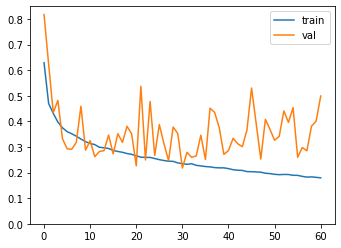

In [13]:
DECODED_LOSS_WEIGHT = 2.0
REQS_LOSS_WEIGHT = 1.0
EYES_LOSS_WEIGHT = 1.0

mlflow.log_param("decoded loss weight", DECODED_LOSS_WEIGHT)
mlflow.log_param("reqs loss weight", REQS_LOSS_WEIGHT)
mlflow.log_param("eyes loss weight", EYES_LOSS_WEIGHT)

losses = {
    "decoded": "mean_squared_error",
    "output_reqs": "binary_crossentropy",
    "output_eyes": "mean_squared_error"
}

loss_weights = {
    "decoded": DECODED_LOSS_WEIGHT,
    "output_reqs": REQS_LOSS_WEIGHT,
    "output_eyes": EYES_LOSS_WEIGHT,
}

metrics = {
    "output_reqs": ["accuracy", precision, recall, f1, fbeta, specificity, npv, mcc],
    "output_eyes": ["mae"]
}
METRIC_TO_MONITOR = "val_output_reqs_fbeta"

outputs_train = {
    "decoded": x_train,
    "output_reqs": y_train_reqs,
    "output_eyes": y_train_eyes,
}

outputs_valid = {
    "decoded": x_val,
    "output_reqs": y_val_reqs,
    "output_eyes": y_val_eyes,
}

model.compile(optimizer='adam', loss=losses, loss_weights=loss_weights, metrics=metrics)

FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix="multilearner_")
list_callbacks = [
    ModelCheckpoint(FILE_MODEL, monitor=METRIC_TO_MONITOR, mode="max", verbose=1, save_best_only=True), 
    EarlyStopping(monitor=METRIC_TO_MONITOR, mode="max", patience=30, verbose=1, restore_best_weights=True)
]

hist = model.fit(
    x=x_train,
    y=outputs_train,
    batch_size=32,
    epochs=100,
    validation_data=(x_val, outputs_valid),
    callbacks=list_callbacks
)

plot.keras_hist(hist.history)

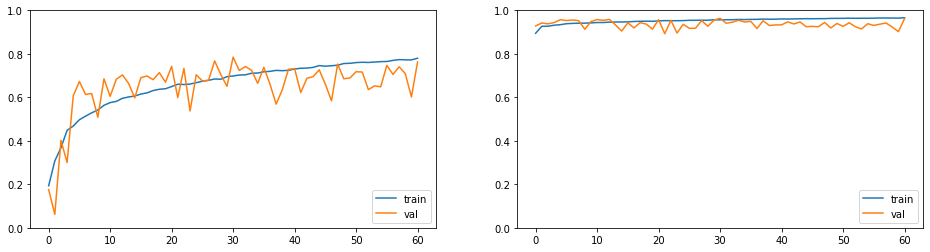

In [14]:
history = hist.history

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(history['output_reqs_matthews_correlation_coefficient'], label='train')
plt.plot(history['val_output_reqs_matthews_correlation_coefficient'], label='val')
plt.ylim(0, 1)
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history['output_reqs_fbeta'], label='train')
plt.plot(history['val_output_reqs_fbeta'], label='val')
plt.ylim(0, 1)
plt.legend(loc='lower right')

# Test Model

[1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]
[0.4015852  0.46103038 0.4663144  0.46367239 0.54161162 0.4663144
 0.60898283 0.47027741]
[0.37834245 0.4515819  0.44496402 0.4580694  0.53321373 0.4498786
 0.5960919  0.4490065 ]


Text(0.5, 1.0, 'decoded image')

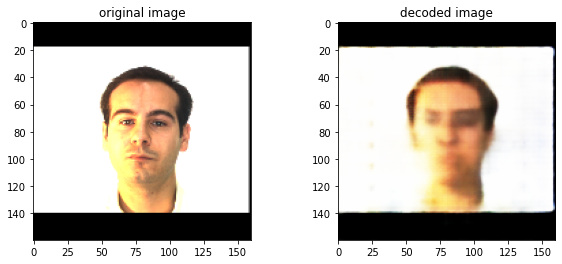

In [15]:
random_idx = np.random.choice(x_val.shape[0])
im = np.expand_dims(x_val[random_idx], axis=0)
y_true_reqs = y_val_reqs[random_idx]
y_true_eyes = y_val_eyes[random_idx]

y_pred_decoded, y_pred_reqs, y_pred_eyes = model.predict(im)
y_pred_reqs = np.where(y_pred_reqs > 0.5, 1, 0)

print(y_true_reqs, y_pred_reqs[0], sep='\n')
print(y_true_eyes, y_pred_eyes[0], sep='\n')

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(im.squeeze()[:, :, ::-1])
plt.title('original image')

plt.subplot(1, 2, 2)
plt.imshow(y_pred_decoded.squeeze()[:, :, ::-1])
plt.title('decoded image')

# Save Classification Model 

In [16]:
FILE_MODEL_CLF = FILE_MODEL.replace('multilearner', 'model')
print(FILE_MODEL_CLF)

model_clf = Model(
    inputs=model.inputs,
    outputs=[model.get_layer('output_reqs').output, model.get_layer('output_eyes').output],
    name="ICAOnet"
)
model_clf.summary()

model_clf.save(FILE_MODEL_CLF)

../../models/unsupervised_supervised/model_2022_02_13-21_43_00.h5
Model: "ICAOnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 160, 160, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 160, 160, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 160, 160, 32) 0           bn_1[0][0]                       
__________________________

In [17]:
import cv2
from glob import glob

model_clf = load_model(FILE_MODEL_CLF)

list_files = [PATH_TO_ROOT + 'data/cropped_faces/images/afwDB_0.png']
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred_ori = model.predict(im)
y_pred_clf, y_pred_reg = model_clf.predict(im)
assert(np.allclose(y_pred_ori[1], y_pred_clf))
assert(np.allclose(y_pred_ori[2], y_pred_reg))

print("Reqs:")
for y_pred in y_pred_clf[0]:
    print(y_pred)

print("\nEyes:")
for y_pred in y_pred_reg[0]:
    print(y_pred)

../../data/cropped_faces/images/afwDB_0.png


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '



Reqs:
0.8769035
0.86185724
0.99792683
0.062069833
0.55381674
0.9938916
0.95897526
0.38407108
0.9731679
0.8351941
0.65358216
0.20434678
0.99263215
0.88039076
0.7003437
0.99974597
0.9949071
0.9999721
0.99739003
0.9975877
0.9830835
0.8072319
0.99968636

Eyes:
0.41064942
0.45644334
0.47298798
0.46379057
0.5702878
0.46579364
0.6252252
0.45357656


# Embeddings Visualization 

In [18]:
FOLDER_LOGS = '../../logs/unsupervised_supervised/'

### Metadata 

In [19]:
image_files = np.array(dataset.image_files)[x_val_idx]
data = dataset.images[x_val_idx]
mrks = dataset.mrks[x_val_idx]

image_files = [basename(filepath) for filepath in image_files]
print(len(image_files))
print(data.shape)

580
(580, 160, 160, 3)


In [20]:
with open(f'{FOLDER_LOGS}/metadata.tsv', 'w') as metadata_file:
    for file in image_files:
        metadata_file.write(file+'\n')

mlflow.log_artifact(f'{FOLDER_LOGS}/metadata.tsv')

### Image Sprite

In [21]:
def images_to_sprite(data):
    """Creates the sprite image along with any necessary padding
    Args:
      data: NxHxW[x3] tensor containing the images.
    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))
    data = data.astype(np.float32)
    min_data = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) - min_data).transpose(3,0,1,2)
    max_data = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) / max_data).transpose(3,0,1,2)

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0), (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=0)
    
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    return data### Embeddings 

In [22]:
im_sprite = images_to_sprite(data)
print(im_sprite.shape)

cv2.imwrite(f'{FOLDER_LOGS}/sprites.png', im_sprite)
mlflow.log_artifact(f'{FOLDER_LOGS}/sprites.png')

(4000, 4000, 3)


### Embeddings 

In [23]:
model = load_model(FILE_MODEL_CLF)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

model_emb = Model(inputs=model.inputs, outputs=embeddings)
model_emb.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 160, 160, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 160, 160, 32)      896       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 160, 160, 32)      128       
_________________________________________________________________
relu_1 (Activation)          (None, 160, 160, 32)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 80, 80, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 80, 80, 64)        18496     
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 80, 80, 64)        256 

In [24]:
emb_vectors = model_emb.predict(data)
print(emb_vectors.shape)

(580, 256)


### Tensorboard 

In [25]:
sess = tf.InteractiveSession()

tf_embeddings = tf.Variable(emb_vectors, name='embeddings')
summary_writer = tf.summary.FileWriter(f'{FOLDER_LOGS}')

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = tf_embeddings.name
embedding.metadata_path = 'metadata.tsv'
embedding.sprite.image_path = 'sprites.png'
embedding.sprite.single_image_dim.extend(IMAGE_SIZE)

projector.visualize_embeddings(summary_writer, config)

saver = tf.train.Saver([tf_embeddings])
sess.run(tf_embeddings.initializer)
saver.save(sess, f'{FOLDER_LOGS}/embeddings.ckpt')

sess.close()

In [26]:
mlflow.end_run()